# Predicting Vaccination Cleaning & EDA

Anaysis by Corey Hanson & Frank Flavell

![](img/pred_vacc_clean_eda.png)

## Table of Contents<span id="0"></span>

1. [**Data Import & Cleaning**](#1)
    * Imputed values to update NaN values
    * Renaming Values
    * Binary Values
2. [**Target Class Imbalance Check**](#2)
    * H1N1 Check
    * Seasonal Check
3. [**Feature to Target Analysis**](#3)
    * Behavioral
    * Opinions
    * Demographic
    * Analysis
4. [**Feature Signficance**](#4)
    * Hypothesis Testing using Chi-Square to determine Significance
    * Multi-comparison to determine significance between feature classes
    * Analysis
5. [**Feature Engineering**](#5)
    * Interaction development
    * Correlation check
    * Analysis

# Package Import

In [1]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

#Local PY files
from cleaning_functions import *
from eda import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

# Configure matplotlib for jupyter.
%matplotlib inline

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <span id="1"></span>1. Data Import & Review
#### [Return Contents](#0)

In the previous notebook dedicated to data cleaning, we took the .csv file provided and updated it by dealing with missing values, converting categorical data into dummy variables, and preparing the data for analysis and modeling.  We saved this cleaned dataset as a new file and we are importing it here to begin our exploratory data analysis.



In [2]:
#Imports the dataframes
dffo = pd.read_csv("data/submission_format.csv")
dftr = pd.read_csv("data/training_set_features.csv")
dfte = pd.read_csv("data/test_set_features.csv")
dfla = pd.read_csv("data/training_set_labels.csv")

#Combines them into a single dataframe
df = pd.merge(dftr, dfla, on="respondent_id")
df = df.set_index("respondent_id")

In [3]:
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [7]:
df.shape

(26707, 38)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
respondent_id                  26707 non-null int64
h1n1_concern                   26615 non-null float64
h1n1_knowledge                 26591 non-null float64
behavioral_antiviral_meds      26636 non-null float64
behavioral_avoidance           26499 non-null float64
behavioral_face_mask           26688 non-null float64
behavioral_wash_hands          26665 non-null float64
behavioral_large_gatherings    26620 non-null float64
behavioral_outside_home        26625 non-null float64
behavioral_touch_face          26579 non-null float64
doctor_recc_h1n1               24547 non-null float64
doctor_recc_seasonal           24547 non-null float64
chronic_med_condition          25736 non-null float64
child_under_6_months           25887 non-null float64
health_worker                  25903 non-null float64
health_insurance               14433 non-null float64
opinion_h1n1_vacc_effective  

In [4]:
full_value_counts(df, 'h1n1_concern')

There are 5 unique values with 92 nan values making up 0.3%
10575-2.0 --39.60%
8153-1.0 --30.53%
4591-3.0 --17.19%
3296-0.0 --12.34%


# Data Cleaning

In [3]:
#Cleaning steps to do before column names are established.
df = initial_cleaning(df)

#Lists of columns to be fed into the model processor object and the functions that
#manage imputed values for the nans.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
ordinal_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
continuous_columns = ["household_adults", "household_children"]

#Function to generate a dictionary that manages impute strategies depending on
#the type of data.
impute_dict = gen_impute_dict(binary_columns, ordinal_columns, continuous_columns)

#Cleans the rest of the data and stores the fitted imputer objects into a list for later use.
df, imputes = fit_clean_data(df, impute_dict)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26707 non-null  float64
 1   h1n1_knowledge               26707 non-null  float64
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
 9   doctor_recc_h1n1             26707 non-null  float64
 10  doctor_recc_seasonal         26707 non-null  float64
 11  chronic_med_condition        26707 non-null  float64
 12  child_under_6_months         26707 non-null  float64
 13  health_worker   

In [8]:
# Saves a copy of the dataframe in it's cleaned state
df.to_pickle("data.pickle")
df = pd.read_pickle('data.pickle')

In [35]:
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_behavioral_antiviral_meds,missing_behavioral_avoidance,missing_behavioral_face_mask,missing_behavioral_wash_hands,missing_behavioral_large_gatherings,missing_behavioral_outside_home,missing_behavioral_touch_face,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_h1n1_concern,missing_h1n1_knowledge,missing_household,missing_opinion
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [36]:
df.shape

(26707, 51)

In [9]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner',
       'missing_household', 'missing_opinion', 'missi

In [38]:
h1n1 = 'h1n1_vaccine'

seas = 'seasonal_vaccine'

behav = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face']

op = ['h1n1_concern', 'h1n1_knowledge','opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc','doctor_recc_h1n1', 'doctor_recc_seasonal']

dem = ['age_group','education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'household_adults', 
       'household_children', 'chronic_med_condition', 'child_under_6_months']

# <span id="2"></span>2. Check for Class Imbalance
#### [Return Contents](#0)

We developed a user-defined function that checks for class imbalance on the target variable.  The function prints a class summary, calculates the percentage of observations in each class and graphs the number of observations in each class.

We determined there is a significant class imblanace between the H1N1 vaccination categories.  We will be addressed before modeling.

We determined there is not a significant class imblanace between the seasonal vaccination categories.

Target Variable: h1n1_vaccine


h1n1_vaccine
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


Percentages
h1n1_vaccine
0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


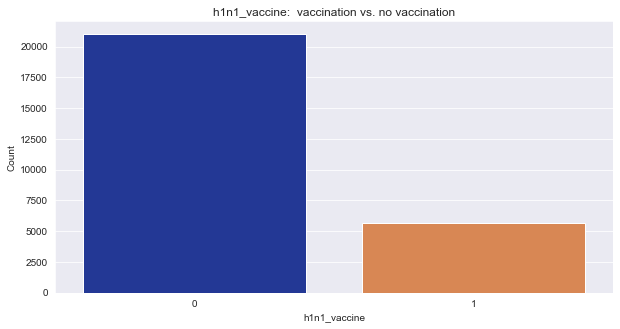

<Figure size 432x288 with 0 Axes>

In [96]:
imbal_graph(df, h1n1, 'vaccination vs. no vaccination')

Target Variable: seasonal_vaccine


seasonal_vaccine
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


Percentages
seasonal_vaccine
0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64


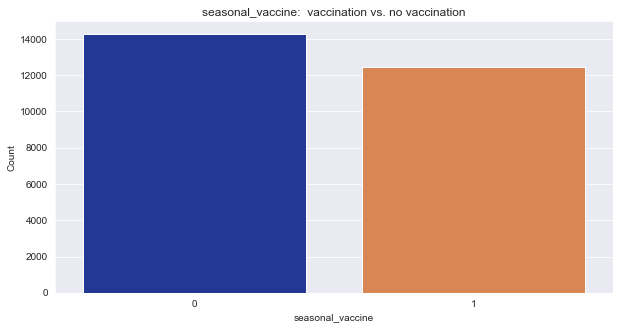

<Figure size 432x288 with 0 Axes>

In [97]:
imbal_graph(df, seas, 'vaccination vs. no vaccination')

# <span id="3"></span>3. Feature to Target Analysis
#### [Return Contents](#0)
<hr/>

We developed a user-defined function that iterates over a list of feature variables (columns) within our dataframe to print a summary of the distribution of target classes based on each feature variable.  The function also calcualtes the percentage of observations in each target class and feature class and graphs a stacked barchart so we can visualize the distribution.

### Behavioral Features to Seasonal Vaccination Target

Anti-Viral Meds: 
  * Majority: Do not take anti-viral meds = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

Avoidance: 
  * Majority: Avoid contact = 1
  * Target Proportion: aprox. even
  * Probably no correlation with target

Face Mask:
  * Majority: Do not wear mask = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

**Wash Hands:**
  * Majority: Wash Hands = 1
  * Target Proportion: slightly higher proportion vaccinate who also wash hands
  * Possible correlation with target

Reduced Large Gatherings:
  * Majority: Do not avoid gatherings = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

Stay Home:
  * Majority: Do Not Stay Home = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

**Touch Face:**
  * Majority: Touch face
  * Target Proportion: slightly higher proportion of people who touch face also vaccinate.
  * Possible correlation with target

behavioral_antiviral_meds seasonal_vaccine summary


seasonal_vaccine               0      1
behavioral_antiviral_meds              
0.0                        13594  11812
1.0                          678    623
seasonal_vaccine                  0         1
behavioral_antiviral_meds                    
0.0                        0.952494  0.949899
1.0                        0.047506  0.050101
seasonal_vaccine                  0         1
behavioral_antiviral_meds                    
0.0                        0.535070  0.464930
1.0                        0.521138  0.478862


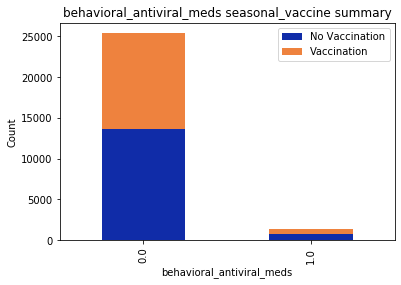

behavioral_avoidance seasonal_vaccine summary


seasonal_vaccine         0     1
behavioral_avoidance            
0.0                   4337  2934
1.0                   9935  9501
seasonal_vaccine             0         1
behavioral_avoidance                    
0.0                   0.303882  0.235947
1.0                   0.696118  0.764053
seasonal_vaccine             0         1
behavioral_avoidance                    
0.0                   0.596479  0.403521
1.0                   0.511165  0.488835


<Figure size 432x288 with 0 Axes>

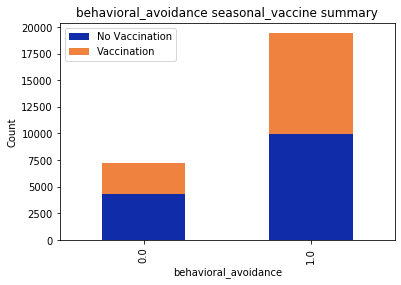

behavioral_face_mask seasonal_vaccine summary


seasonal_vaccine          0      1
behavioral_face_mask              
0.0                   13457  11409
1.0                     815   1026
seasonal_vaccine             0         1
behavioral_face_mask                    
0.0                   0.942895  0.917491
1.0                   0.057105  0.082509
seasonal_vaccine             0         1
behavioral_face_mask                    
0.0                   0.541181  0.458819
1.0                   0.442694  0.557306


<Figure size 432x288 with 0 Axes>

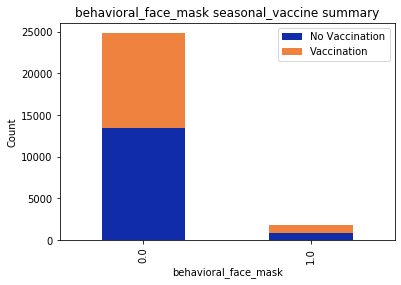

behavioral_wash_hands seasonal_vaccine summary


seasonal_vaccine           0      1
behavioral_wash_hands              
0.0                     3052   1598
1.0                    11220  10837
seasonal_vaccine              0         1
behavioral_wash_hands                    
0.0                    0.213845  0.128508
1.0                    0.786155  0.871492
seasonal_vaccine              0         1
behavioral_wash_hands                    
0.0                    0.656344  0.343656
1.0                    0.508682  0.491318


<Figure size 432x288 with 0 Axes>

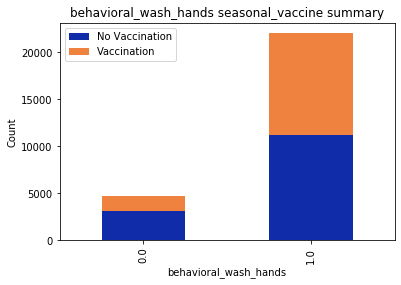

behavioral_large_gatherings seasonal_vaccine summary


seasonal_vaccine                0     1
behavioral_large_gatherings            
0.0                          9577  7583
1.0                          4695  4852
seasonal_vaccine                    0         1
behavioral_large_gatherings                    
0.0                          0.671034  0.609811
1.0                          0.328966  0.390189
seasonal_vaccine                    0         1
behavioral_large_gatherings                    
0.0                          0.558100  0.441900
1.0                          0.491778  0.508222


<Figure size 432x288 with 0 Axes>

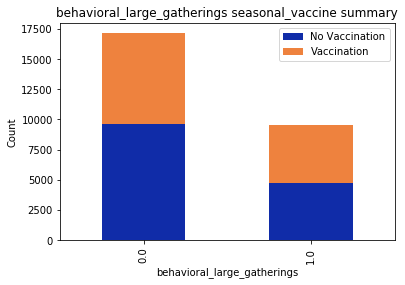

behavioral_outside_home seasonal_vaccine summary


seasonal_vaccine            0     1
behavioral_outside_home            
0.0                      9808  7918
1.0                      4464  4517
seasonal_vaccine               0         1
behavioral_outside_home                   
0.0                      0.68722  0.636751
1.0                      0.31278  0.363249
seasonal_vaccine                0         1
behavioral_outside_home                    
0.0                      0.553312  0.446688
1.0                      0.497049  0.502951


<Figure size 432x288 with 0 Axes>

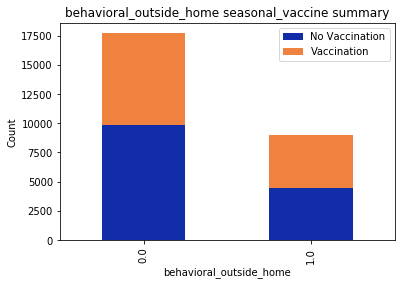

behavioral_touch_face seasonal_vaccine summary


seasonal_vaccine          0     1
behavioral_touch_face            
0.0                    5330  3248
1.0                    8942  9187
seasonal_vaccine              0         1
behavioral_touch_face                    
0.0                    0.373459  0.261198
1.0                    0.626541  0.738802
seasonal_vaccine              0         1
behavioral_touch_face                    
0.0                    0.621357  0.378643
1.0                    0.493243  0.506757


<Figure size 432x288 with 0 Axes>

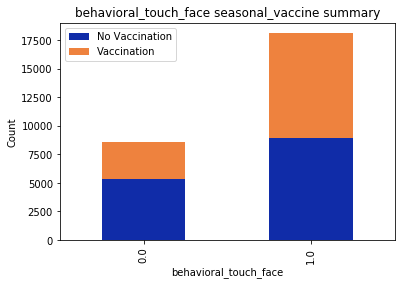

<Figure size 432x288 with 0 Axes>

In [68]:
stacked(df, behav, seas, ['No Vaccination', 'Vaccination'])

### Behavioral Features to H1N1 Vaccination Target

Anti-Viral Meds: 
  * Majority: Do not take anti-viral meds = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

**Avoidance:** 
  * Majority: Avoid contact = 1
  * Target Proportion: Slightly higher proportion vaccinate who avoid contact
  * Possible correlation with target

***Face Mask:***
  * Majority: Do not wear mask = 0
  * Target Proportion: slightly higher proportion vaccinate who wear face mask
  * Possible correlation with target

Wash Hands:
  * Majority: Wash Hands = 1
  * Target Proportion: approx. even
  * Probably no correlation with target

Reduced Large Gatherings:
  * Majority: Do not avoid gatherings = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

Stay Home:
  * Majority: Do Not Stay Home = 0
  * Target Proportion: aprox. even
  * Probably no correlation with target

**Touch Face**:
  * Majority: Touch face
  * Target Proportion: slightly higher proportion of people who touch face also vaccinate.
  * Possible correlation with target

behavioral_antiviral_meds h1n1_vaccine summary


h1n1_vaccine                   0     1
behavioral_antiviral_meds             
0.0                        20103  5303
1.0                          930   371
h1n1_vaccine                      0         1
behavioral_antiviral_meds                    
0.0                        0.955784  0.934614
1.0                        0.044216  0.065386
h1n1_vaccine                      0         1
behavioral_antiviral_meds                    
0.0                        0.791270  0.208730
1.0                        0.714835  0.285165


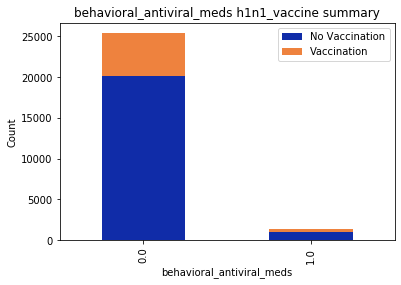

behavioral_avoidance h1n1_vaccine summary


h1n1_vaccine              0     1
behavioral_avoidance             
0.0                    5954  1317
1.0                   15079  4357
h1n1_vaccine                 0         1
behavioral_avoidance                    
0.0                   0.283079  0.232111
1.0                   0.716921  0.767889
h1n1_vaccine                 0         1
behavioral_avoidance                    
0.0                   0.818869  0.181131
1.0                   0.775828  0.224172


<Figure size 432x288 with 0 Axes>

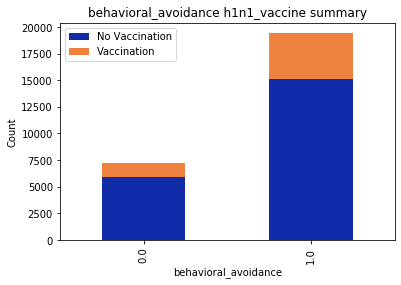

behavioral_face_mask h1n1_vaccine summary


h1n1_vaccine              0     1
behavioral_face_mask             
0.0                   19778  5088
1.0                    1255   586
h1n1_vaccine                 0         1
behavioral_face_mask                    
0.0                   0.940332  0.896722
1.0                   0.059668  0.103278
h1n1_vaccine                 0         1
behavioral_face_mask                    
0.0                   0.795383  0.204617
1.0                   0.681695  0.318305


<Figure size 432x288 with 0 Axes>

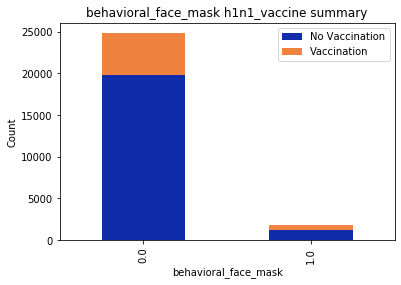

behavioral_wash_hands h1n1_vaccine summary


h1n1_vaccine               0     1
behavioral_wash_hands             
0.0                     3971   679
1.0                    17062  4995
h1n1_vaccine                  0         1
behavioral_wash_hands                    
0.0                    0.188799  0.119669
1.0                    0.811201  0.880331
h1n1_vaccine                  0         1
behavioral_wash_hands                    
0.0                    0.853978  0.146022
1.0                    0.773541  0.226459


<Figure size 432x288 with 0 Axes>

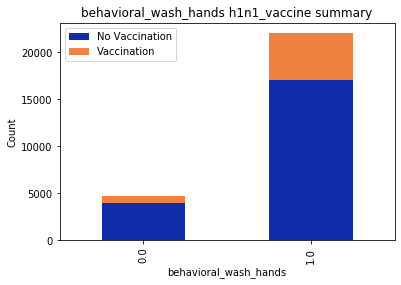

behavioral_large_gatherings h1n1_vaccine summary


h1n1_vaccine                     0     1
behavioral_large_gatherings             
0.0                          13609  3551
1.0                           7424  2123
h1n1_vaccine                        0         1
behavioral_large_gatherings                    
0.0                          0.647031  0.625837
1.0                          0.352969  0.374163
h1n1_vaccine                        0         1
behavioral_large_gatherings                    
0.0                          0.793065  0.206935
1.0                          0.777626  0.222374


<Figure size 432x288 with 0 Axes>

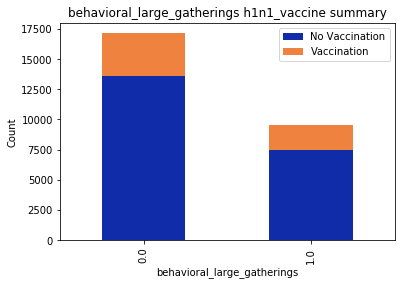

behavioral_outside_home h1n1_vaccine summary


h1n1_vaccine                 0     1
behavioral_outside_home             
0.0                      14074  3652
1.0                       6959  2022
h1n1_vaccine                    0         1
behavioral_outside_home                    
0.0                      0.669139  0.643638
1.0                      0.330861  0.356362
h1n1_vaccine                    0         1
behavioral_outside_home                    
0.0                      0.793975  0.206025
1.0                      0.774858  0.225142


<Figure size 432x288 with 0 Axes>

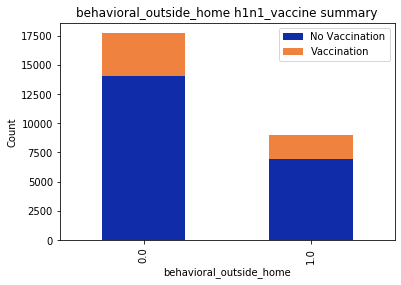

behavioral_touch_face h1n1_vaccine summary


h1n1_vaccine               0     1
behavioral_touch_face             
0.0                     7117  1461
1.0                    13916  4213
h1n1_vaccine                  0        1
behavioral_touch_face                   
0.0                    0.338373  0.25749
1.0                    0.661627  0.74251
h1n1_vaccine                  0         1
behavioral_touch_face                    
0.0                    0.829681  0.170319
1.0                    0.767610  0.232390


<Figure size 432x288 with 0 Axes>

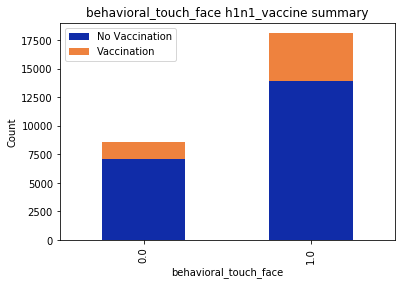

<Figure size 432x288 with 0 Axes>

In [69]:
stacked(df, behav, h1n1, ['No Vaccination', 'Vaccination'])

### Opinion Features to Seasonal Vaccination Target

h1n1_concern seasonal_vaccine summary


seasonal_vaccine     0     1
h1n1_concern                
0.0               2254  1042
1.0               4811  3342
2.0               5185  5482
3.0               2022  2569
seasonal_vaccine         0         1
h1n1_concern                        
0.0               0.157932  0.083796
1.0               0.337094  0.268758
2.0               0.363299  0.440852
3.0               0.141676  0.206594
seasonal_vaccine         0         1
h1n1_concern                        
0.0               0.683859  0.316141
1.0               0.590090  0.409910
2.0               0.486079  0.513921
3.0               0.440427  0.559573


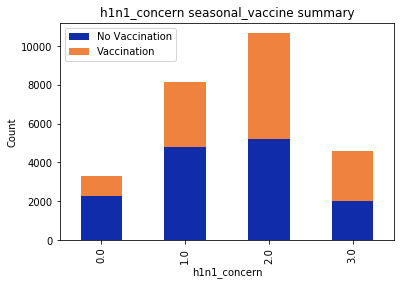

h1n1_knowledge seasonal_vaccine summary


seasonal_vaccine     0     1
h1n1_knowledge              
0.0               1588   918
1.0               8350  6364
2.0               4334  5153
seasonal_vaccine         0         1
h1n1_knowledge                      
0.0               0.111267  0.073824
1.0               0.585062  0.511781
2.0               0.303672  0.414395
seasonal_vaccine         0         1
h1n1_knowledge                      
0.0               0.633679  0.366321
1.0               0.567487  0.432513
2.0               0.456836  0.543164


<Figure size 432x288 with 0 Axes>

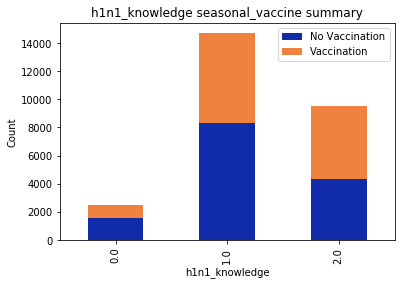

opinion_h1n1_vacc_effective seasonal_vaccine summary


seasonal_vaccine                0     1
opinion_h1n1_vacc_effective            
1.0                           699   187
2.0                          1381   477
3.0                          2727  1996
4.0                          6687  5387
5.0                          2778  4388
seasonal_vaccine                    0         1
opinion_h1n1_vacc_effective                    
1.0                          0.048977  0.015038
2.0                          0.096763  0.038359
3.0                          0.191073  0.160515
4.0                          0.468540  0.433213
5.0                          0.194647  0.352875
seasonal_vaccine                    0         1
opinion_h1n1_vacc_effective                    
1.0                          0.788939  0.211061
2.0                          0.743272  0.256728
3.0                          0.577387  0.422613
4.0                          0.553835  0.446165
5.0                          0.387664  0.

<Figure size 432x288 with 0 Axes>

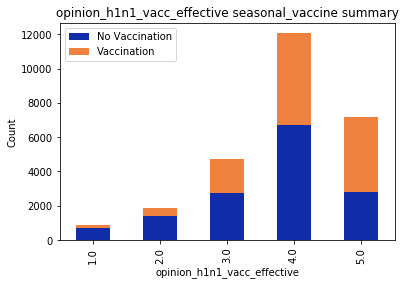

opinion_h1n1_risk seasonal_vaccine summary


seasonal_vaccine      0     1
opinion_h1n1_risk            
1.0                5407  2732
2.0                5643  4664
3.0                 540   577
4.0                2029  3365
5.0                 653  1097
seasonal_vaccine          0         1
opinion_h1n1_risk                    
1.0                0.378854  0.219702
2.0                0.395390  0.375070
3.0                0.037836  0.046401
4.0                0.142166  0.270607
5.0                0.045754  0.088219
seasonal_vaccine          0         1
opinion_h1n1_risk                    
1.0                0.664332  0.335668
2.0                0.547492  0.452508
3.0                0.483438  0.516562
4.0                0.376159  0.623841
5.0                0.373143  0.626857


<Figure size 432x288 with 0 Axes>

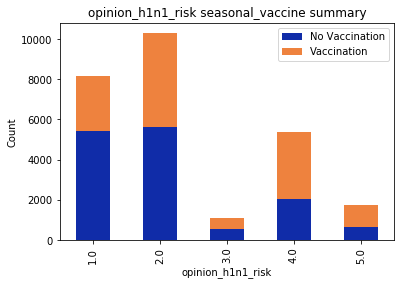

opinion_h1n1_sick_from_vacc seasonal_vaccine summary


seasonal_vaccine                0     1
opinion_h1n1_sick_from_vacc            
1.0                          4986  4012
2.0                          5087  4437
3.0                            86    62
4.0                          2914  2936
5.0                          1199   988
seasonal_vaccine                    0         1
opinion_h1n1_sick_from_vacc                    
1.0                          0.349355  0.322638
2.0                          0.356432  0.356815
3.0                          0.006026  0.004986
4.0                          0.204176  0.236108
5.0                          0.084011  0.079453
seasonal_vaccine                    0         1
opinion_h1n1_sick_from_vacc                    
1.0                          0.554123  0.445877
2.0                          0.534124  0.465876
3.0                          0.581081  0.418919
4.0                          0.498120  0.501880
5.0                          0.548240  0.

<Figure size 432x288 with 0 Axes>

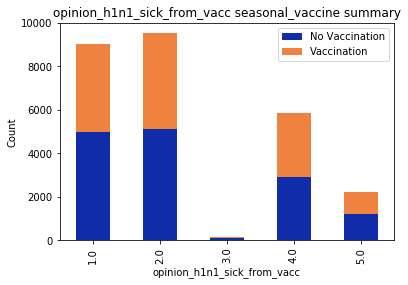

opinion_seas_vacc_effective seasonal_vaccine summary


seasonal_vaccine                0     1
opinion_seas_vacc_effective            
1.0                          1028   193
2.0                          1885   321
3.0                           876   340
4.0                          7538  4553
5.0                          2945  7028
seasonal_vaccine                    0         1
opinion_seas_vacc_effective                    
1.0                          0.072029  0.015521
2.0                          0.132077  0.025814
3.0                          0.061379  0.027342
4.0                          0.528167  0.366144
5.0                          0.206348  0.565179
seasonal_vaccine                    0         1
opinion_seas_vacc_effective                    
1.0                          0.841933  0.158067
2.0                          0.854488  0.145512
3.0                          0.720395  0.279605
4.0                          0.623439  0.376561
5.0                          0.295297  0.

<Figure size 432x288 with 0 Axes>

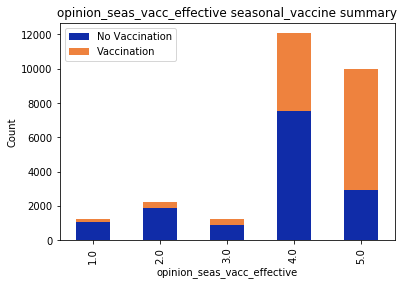

opinion_seas_risk seasonal_vaccine summary


seasonal_vaccine      0     1
opinion_seas_risk            
1.0                4723  1251
2.0                5926  3542
3.0                 300   377
4.0                2568  5062
5.0                 755  2203
seasonal_vaccine          0         1
opinion_seas_risk                    
1.0                0.330928  0.100603
2.0                0.415219  0.284841
3.0                0.021020  0.030318
4.0                0.179933  0.407077
5.0                0.052901  0.177161
seasonal_vaccine          0         1
opinion_seas_risk                    
1.0                0.790593  0.209407
2.0                0.625898  0.374102
3.0                0.443131  0.556869
4.0                0.336566  0.663434
5.0                0.255240  0.744760


<Figure size 432x288 with 0 Axes>

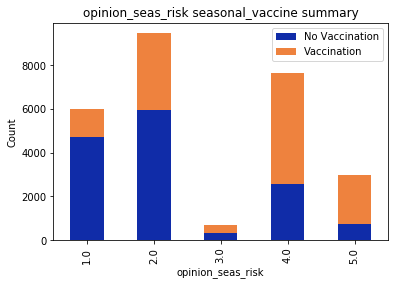

opinion_seas_sick_from_vacc seasonal_vaccine summary


seasonal_vaccine                0     1
opinion_seas_sick_from_vacc            
1.0                          5782  6088
2.0                          4732  3438
3.0                            77    17
4.0                          2622  2230
5.0                          1059   662
seasonal_vaccine                    0         1
opinion_seas_sick_from_vacc                    
1.0                          0.405129  0.489586
2.0                          0.331558  0.276478
3.0                          0.005395  0.001367
4.0                          0.183716  0.179333
5.0                          0.074201  0.053237
seasonal_vaccine                    0         1
opinion_seas_sick_from_vacc                    
1.0                          0.487110  0.512890
2.0                          0.579192  0.420808
3.0                          0.819149  0.180851
4.0                          0.540396  0.459604
5.0                          0.615340  0.

<Figure size 432x288 with 0 Axes>

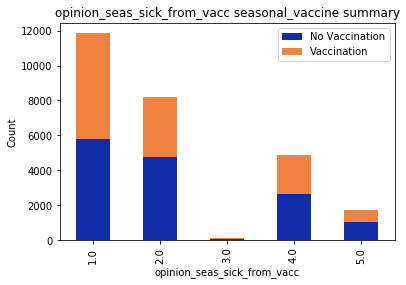

doctor_recc_h1n1 seasonal_vaccine summary


seasonal_vaccine      0     1
doctor_recc_h1n1             
0.0               12445  8854
1.0                1827  3581
seasonal_vaccine         0         1
doctor_recc_h1n1                    
0.0               0.871987  0.712023
1.0               0.128013  0.287977
seasonal_vaccine         0         1
doctor_recc_h1n1                    
0.0               0.584300  0.415700
1.0               0.337833  0.662167


<Figure size 432x288 with 0 Axes>

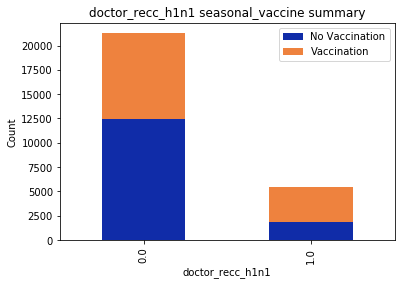

doctor_recc_seasonal seasonal_vaccine summary


seasonal_vaccine          0     1
doctor_recc_seasonal             
0.0                   12155  6458
1.0                    2117  5977
seasonal_vaccine             0         1
doctor_recc_seasonal                    
0.0                   0.851668  0.519341
1.0                   0.148332  0.480659
seasonal_vaccine             0         1
doctor_recc_seasonal                    
0.0                   0.653038  0.346962
1.0                   0.261552  0.738448


<Figure size 432x288 with 0 Axes>

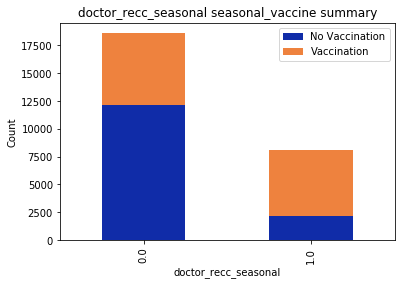

<Figure size 432x288 with 0 Axes>

In [70]:
stacked(df, op, seas, ['No Vaccination', 'Vaccination'])

### Opinion Features to H1N1 Vaccination Target

Analysis

h1n1_concern h1n1_vaccine summary


h1n1_vaccine     0     1
h1n1_concern            
0.0           2849   447
1.0           6756  1397
2.0           8178  2489
3.0           3250  1341
h1n1_vaccine         0         1
h1n1_concern                    
0.0           0.135454  0.078780
1.0           0.321210  0.246211
2.0           0.388818  0.438668
3.0           0.154519  0.236341
h1n1_vaccine         0         1
h1n1_concern                    
0.0           0.864381  0.135619
1.0           0.828652  0.171348
2.0           0.766664  0.233336
3.0           0.707907  0.292093


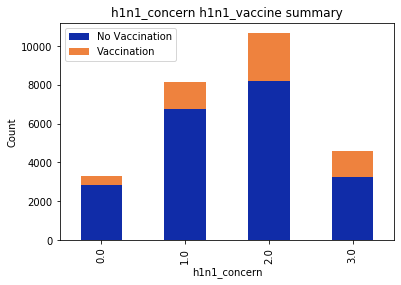

h1n1_knowledge h1n1_vaccine summary


h1n1_vaccine        0     1
h1n1_knowledge             
0.0              2145   361
1.0             12039  2675
2.0              6849  2638
h1n1_vaccine           0         1
h1n1_knowledge                    
0.0             0.101983  0.063624
1.0             0.572386  0.471449
2.0             0.325631  0.464928
h1n1_vaccine           0         1
h1n1_knowledge                    
0.0             0.855946  0.144054
1.0             0.818200  0.181800
2.0             0.721935  0.278065


<Figure size 432x288 with 0 Axes>

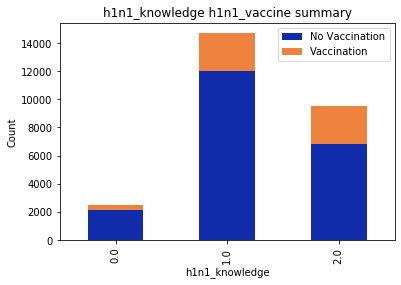

opinion_h1n1_vacc_effective h1n1_vaccine summary


h1n1_vaccine                    0     1
opinion_h1n1_vacc_effective            
1.0                           844    42
2.0                          1763    95
3.0                          4224   499
4.0                          9937  2137
5.0                          4265  2901
h1n1_vaccine                        0         1
opinion_h1n1_vacc_effective                    
1.0                          0.040127  0.007402
2.0                          0.083821  0.016743
3.0                          0.200827  0.087945
4.0                          0.472448  0.376630
5.0                          0.202777  0.511280
h1n1_vaccine                        0         1
opinion_h1n1_vacc_effective                    
1.0                          0.952596  0.047404
2.0                          0.948870  0.051130
3.0                          0.894347  0.105653
4.0                          0.823008  0.176992
5.0                          0.595172  0.4048

<Figure size 432x288 with 0 Axes>

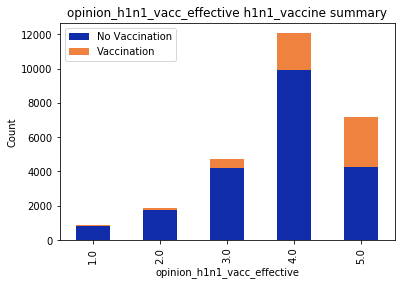

opinion_h1n1_risk h1n1_vaccine summary


h1n1_vaccine          0     1
opinion_h1n1_risk            
1.0                7420   719
2.0                8555  1752
3.0                 923   194
4.0                3279  2115
5.0                 856   894
h1n1_vaccine              0         1
opinion_h1n1_risk                    
1.0                0.352779  0.126718
2.0                0.406742  0.308777
3.0                0.043883  0.034191
4.0                0.155898  0.372753
5.0                0.040698  0.157561
h1n1_vaccine              0         1
opinion_h1n1_risk                    
1.0                0.911660  0.088340
2.0                0.830018  0.169982
3.0                0.826321  0.173679
4.0                0.607898  0.392102
5.0                0.489143  0.510857


<Figure size 432x288 with 0 Axes>

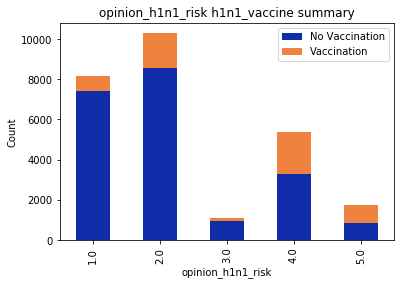

opinion_h1n1_sick_from_vacc h1n1_vaccine summary


h1n1_vaccine                    0     1
opinion_h1n1_sick_from_vacc            
1.0                          7157  1841
2.0                          7862  1662
3.0                           136    12
4.0                          4304  1546
5.0                          1574   613
h1n1_vaccine                        0         1
opinion_h1n1_sick_from_vacc                    
1.0                          0.340275  0.324462
2.0                          0.373794  0.292915
3.0                          0.006466  0.002115
4.0                          0.204631  0.272471
5.0                          0.074835  0.108037
h1n1_vaccine                        0         1
opinion_h1n1_sick_from_vacc                    
1.0                          0.795399  0.204601
2.0                          0.825493  0.174507
3.0                          0.918919  0.081081
4.0                          0.735726  0.264274
5.0                          0.719707  0.2802

<Figure size 432x288 with 0 Axes>

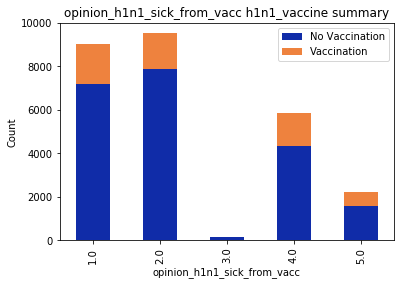

opinion_seas_vacc_effective h1n1_vaccine summary


h1n1_vaccine                    0     1
opinion_seas_vacc_effective            
1.0                          1132    89
2.0                          2001   205
3.0                          1054   162
4.0                          9949  2142
5.0                          6897  3076
h1n1_vaccine                        0         1
opinion_seas_vacc_effective                    
1.0                          0.053820  0.015686
2.0                          0.095136  0.036130
3.0                          0.050112  0.028551
4.0                          0.473019  0.377511
5.0                          0.327913  0.542122
h1n1_vaccine                        0         1
opinion_seas_vacc_effective                    
1.0                          0.927109  0.072891
2.0                          0.907072  0.092928
3.0                          0.866776  0.133224
4.0                          0.822843  0.177157
5.0                          0.691567  0.3084

<Figure size 432x288 with 0 Axes>

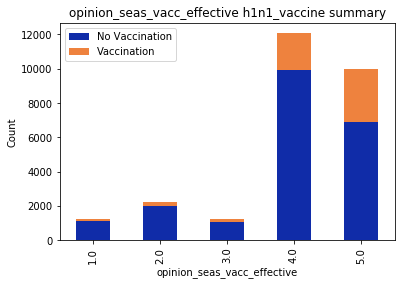

opinion_seas_risk h1n1_vaccine summary


h1n1_vaccine          0     1
opinion_seas_risk            
1.0                5468   506
2.0                7953  1515
3.0                 541   136
4.0                5295  2335
5.0                1776  1182
h1n1_vaccine              0         1
opinion_seas_risk                    
1.0                0.259972  0.089179
2.0                0.378120  0.267007
3.0                0.025721  0.023969
4.0                0.251747  0.411526
5.0                0.084439  0.208319
h1n1_vaccine              0         1
opinion_seas_risk                    
1.0                0.915300  0.084700
2.0                0.839987  0.160013
3.0                0.799114  0.200886
4.0                0.693971  0.306029
5.0                0.600406  0.399594


<Figure size 432x288 with 0 Axes>

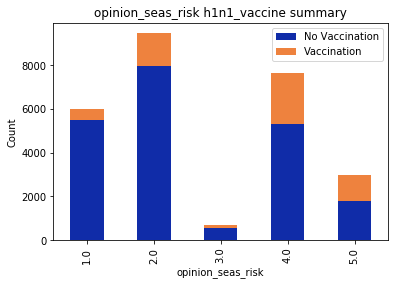

opinion_seas_sick_from_vacc h1n1_vaccine summary


h1n1_vaccine                    0     1
opinion_seas_sick_from_vacc            
1.0                          9252  2618
2.0                          6622  1548
3.0                            86     8
4.0                          3740  1112
5.0                          1333   388
h1n1_vaccine                        0         1
opinion_seas_sick_from_vacc                    
1.0                          0.439880  0.461403
2.0                          0.314839  0.272823
3.0                          0.004089  0.001410
4.0                          0.177816  0.195982
5.0                          0.063377  0.068382
h1n1_vaccine                        0         1
opinion_seas_sick_from_vacc                    
1.0                          0.779444  0.220556
2.0                          0.810526  0.189474
3.0                          0.914894  0.085106
4.0                          0.770816  0.229184
5.0                          0.774550  0.2254

<Figure size 432x288 with 0 Axes>

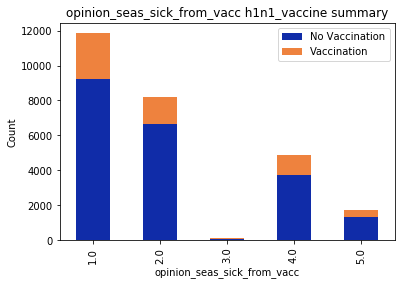

doctor_recc_h1n1 h1n1_vaccine summary


h1n1_vaccine          0     1
doctor_recc_h1n1             
0.0               18504  2795
1.0                2529  2879
h1n1_vaccine            0         1
doctor_recc_h1n1                   
0.0               0.87976  0.492598
1.0               0.12024  0.507402
h1n1_vaccine             0         1
doctor_recc_h1n1                    
0.0               0.868773  0.131227
1.0               0.467641  0.532359


<Figure size 432x288 with 0 Axes>

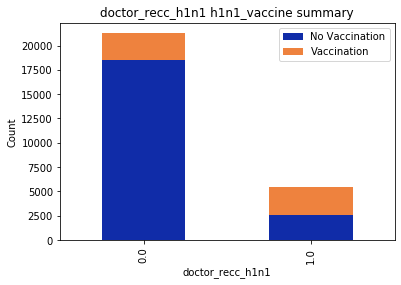

doctor_recc_seasonal h1n1_vaccine summary


h1n1_vaccine              0     1
doctor_recc_seasonal             
0.0                   15758  2855
1.0                    5275  2819
h1n1_vaccine                 0         1
doctor_recc_seasonal                    
0.0                   0.749204  0.503172
1.0                   0.250796  0.496828
h1n1_vaccine                 0         1
doctor_recc_seasonal                    
0.0                   0.846613  0.153387
1.0                   0.651717  0.348283


<Figure size 432x288 with 0 Axes>

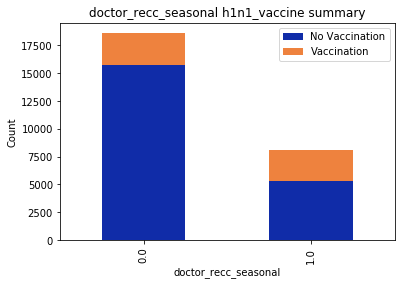

<Figure size 432x288 with 0 Axes>

In [71]:
stacked(df, op, h1n1, ['No Vaccination', 'Vaccination'])

### Demographic Features to Seasonal Vaccination Target

Analysis

age_group summary


seasonal_vaccine     0     1
age_group                   
18 - 34 Years     3731  1484
35 - 44 Years     2453  1395
45 - 54 Years     3136  2102
55 - 64 Years     2719  2844
65+ Years         2233  4610
seasonal_vaccine         0         1
age_group                           
18 - 34 Years     0.261421  0.119341
35 - 44 Years     0.171875  0.112183
45 - 54 Years     0.219731  0.169039
55 - 64 Years     0.190513  0.228709
65+ Years         0.156460  0.370728
seasonal_vaccine         0         1
age_group                           
18 - 34 Years     0.715436  0.284564
35 - 44 Years     0.637474  0.362526
45 - 54 Years     0.598702  0.401298
55 - 64 Years     0.488765  0.511235
65+ Years         0.326319  0.673681


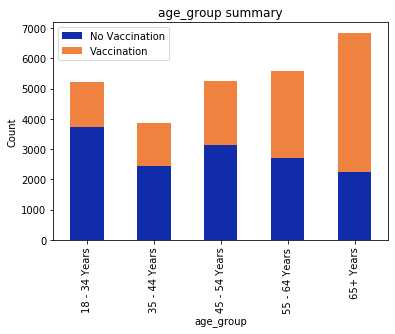

education summary


seasonal_vaccine     0     1
education                   
12 Years          3199  2598
< 12 Years        1415   948
College Graduate  4933  5164
Some College      3860  3183
unknown            865   542
seasonal_vaccine         0         1
education                           
12 Years          0.224145  0.208926
< 12 Years        0.099145  0.076236
College Graduate  0.345642  0.415279
Some College      0.270460  0.255971
unknown           0.060608  0.043587
seasonal_vaccine         0         1
education                           
12 Years          0.551837  0.448163
< 12 Years        0.598815  0.401185
College Graduate  0.488561  0.511439
Some College      0.548062  0.451938
unknown           0.614783  0.385217


<Figure size 432x288 with 0 Axes>

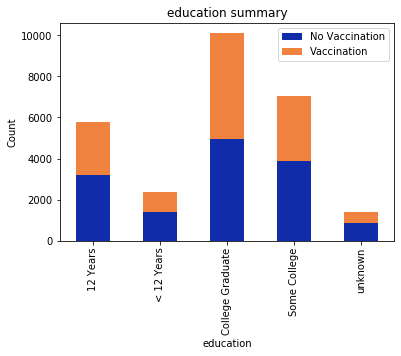

race summary


seasonal_vaccine       0      1
race                           
Black               1377    741
Hispanic            1159    596
Other or Multiple    935    677
White              10801  10421
seasonal_vaccine          0         1
race                                 
Black              0.096483  0.059590
Hispanic           0.081208  0.047929
Other or Multiple  0.065513  0.054443
White              0.756797  0.838038
seasonal_vaccine          0         1
race                                 
Black              0.650142  0.349858
Hispanic           0.660399  0.339601
Other or Multiple  0.580025  0.419975
White              0.508953  0.491047


<Figure size 432x288 with 0 Axes>

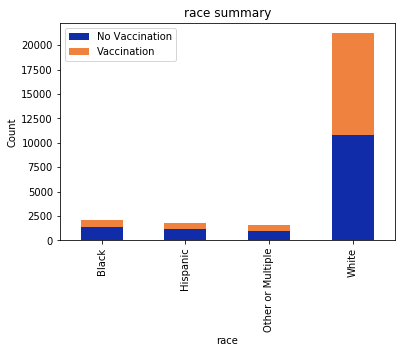

sex summary


seasonal_vaccine     0     1
sex                         
Female            7970  7888
Male              6302  4547
seasonal_vaccine         0         1
sex                                 
Female            0.558436  0.634339
Male              0.441564  0.365661
seasonal_vaccine         0         1
sex                                 
Female            0.502585  0.497415
Male              0.580883  0.419117


<Figure size 432x288 with 0 Axes>

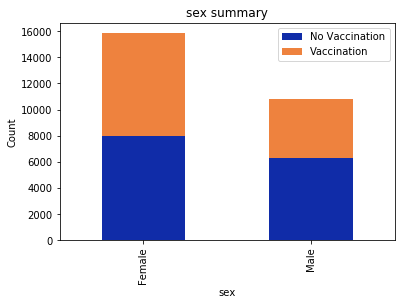

income_poverty summary


seasonal_vaccine     0     1
income_poverty              
Above $75k        3427  3383
Above Poverty     6686  6091
Below Poverty     1719   978
unknown           2440  1983
seasonal_vaccine         0         1
income_poverty                      
Above $75k        0.240121  0.272055
Above Poverty     0.468470  0.489827
Below Poverty     0.120446  0.078649
unknown           0.170964  0.159469
seasonal_vaccine         0         1
income_poverty                      
Above $75k        0.503231  0.496769
Above Poverty     0.523284  0.476716
Below Poverty     0.637375  0.362625
unknown           0.551662  0.448338


<Figure size 432x288 with 0 Axes>

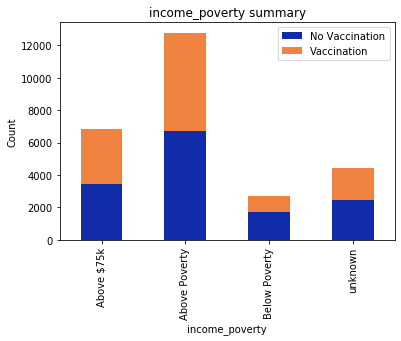

marital_status summary


seasonal_vaccine     0     1
marital_status              
Married           6856  6699
Not Married       6556  5188
unknown            860   548
seasonal_vaccine         0         1
marital_status                      
Married           0.480381  0.538721
Not Married       0.459361  0.417209
unknown           0.060258  0.044069
seasonal_vaccine         0         1
marital_status                      
Married           0.505791  0.494209
Not Married       0.558243  0.441757
unknown           0.610795  0.389205


<Figure size 432x288 with 0 Axes>

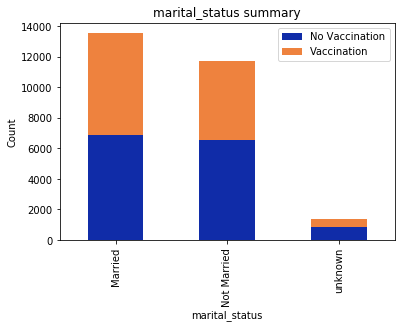

homeowner summary


seasonal_vaccine      0      1
homeowner                     
0.0                3732   2197
1.0               10540  10238
seasonal_vaccine         0         1
homeowner                           
0.0               0.261491  0.176679
1.0               0.738509  0.823321
seasonal_vaccine         0         1
homeowner                           
0.0               0.629448  0.370552
1.0               0.507267  0.492733


<Figure size 432x288 with 0 Axes>

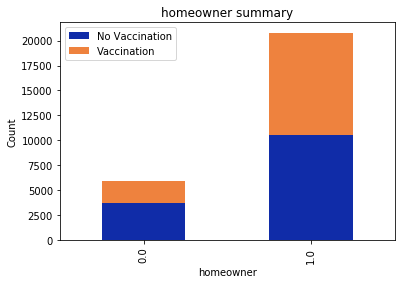

employment_status summary


seasonal_vaccine       0     1
employment_status             
Employed            7839  5721
Not in Labor Force  4523  5708
Unemployed          1014   439
unknown              896   567
seasonal_vaccine           0         1
employment_status                     
Employed            0.549257  0.460072
Not in Labor Force  0.316914  0.459027
Unemployed          0.071048  0.035304
unknown             0.062780  0.045597
seasonal_vaccine           0         1
employment_status                     
Employed            0.578097  0.421903
Not in Labor Force  0.442088  0.557912
Unemployed          0.697866  0.302134
unknown             0.612440  0.387560


<Figure size 432x288 with 0 Axes>

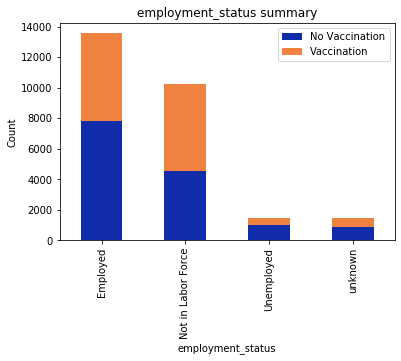

hhs_geo_region summary


seasonal_vaccine     0     1
hhs_geo_region              
atmpeygn          1031  1002
bhuqouqj          1433  1413
dqpwygqj           637   489
fpwskwrf          1717  1548
kbazzjca          1482  1376
lrircsnp          1219   859
lzgpxyit          2349  1948
mlyzmhmf          1235  1008
oxchjgsf          1520  1339
qufhixun          1649  1453
seasonal_vaccine         0         1
hhs_geo_region                      
atmpeygn          0.072239  0.080579
bhuqouqj          0.100406  0.113631
dqpwygqj          0.044633  0.039324
fpwskwrf          0.120305  0.124487
kbazzjca          0.103840  0.110655
lrircsnp          0.085412  0.069079
lzgpxyit          0.164588  0.156655
mlyzmhmf          0.086533  0.081062
oxchjgsf          0.106502  0.107680
qufhixun          0.115541  0.116848
seasonal_vaccine         0         1
hhs_geo_region                      
atmpeygn          0.507132  0.492868
bhuqouqj          0.503514  0.496486
dqpwygqj          0.565719  0.43428

<Figure size 432x288 with 0 Axes>

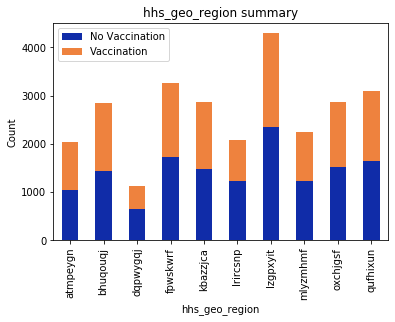

household_adults summary


seasonal_vaccine     0     1
household_adults            
0.0               4079  3977
1.0               7785  6938
2.0               1691  1112
3.0                717   408
seasonal_vaccine         0         1
household_adults                    
0.0               0.285804  0.319823
1.0               0.545474  0.557941
2.0               0.118484  0.089425
3.0               0.050238  0.032811
seasonal_vaccine         0         1
household_adults                    
0.0               0.506331  0.493669
1.0               0.528765  0.471235
2.0               0.603282  0.396718
3.0               0.637333  0.362667


<Figure size 432x288 with 0 Axes>

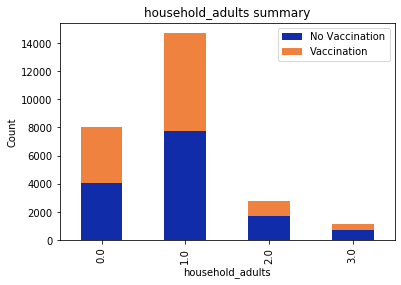

household_children summary


seasonal_vaccine       0     1
household_children            
0.0                 9402  9519
1.0                 1953  1222
2.0                 1769  1095
3.0                 1148   599
seasonal_vaccine           0         1
household_children                    
0.0                 0.658772  0.765501
1.0                 0.136841  0.098271
2.0                 0.123949  0.088058
3.0                 0.080437  0.048170
seasonal_vaccine           0         1
household_children                    
0.0                 0.496908  0.503092
1.0                 0.615118  0.384882
2.0                 0.617668  0.382332
3.0                 0.657127  0.342873


<Figure size 432x288 with 0 Axes>

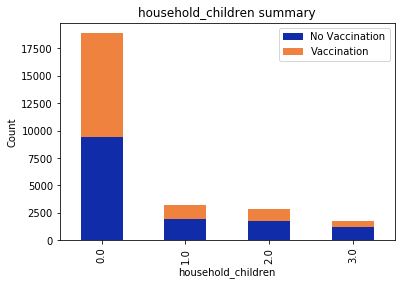

chronic_med_condition summary


seasonal_vaccine           0     1
chronic_med_condition             
0.0                    11382  8035
1.0                     2890  4400
seasonal_vaccine              0        1
chronic_med_condition                   
0.0                    0.797506  0.64616
1.0                    0.202494  0.35384
seasonal_vaccine              0         1
chronic_med_condition                    
0.0                    0.586187  0.413813
1.0                    0.396433  0.603567


<Figure size 432x288 with 0 Axes>

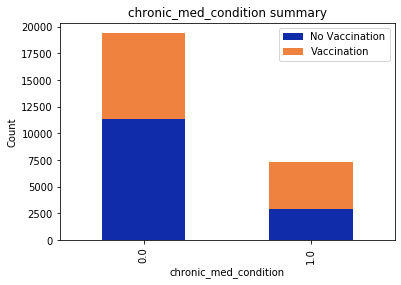

child_under_6_months summary


seasonal_vaccine          0      1
child_under_6_months              
0.0                   13178  11391
1.0                    1094   1044
seasonal_vaccine             0         1
child_under_6_months                    
0.0                   0.923346  0.916043
1.0                   0.076654  0.083957
seasonal_vaccine             0         1
child_under_6_months                    
0.0                   0.536367  0.463633
1.0                   0.511693  0.488307


<Figure size 432x288 with 0 Axes>

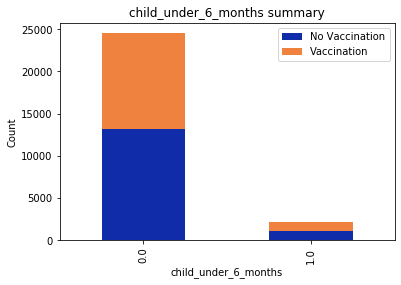

<Figure size 432x288 with 0 Axes>

In [65]:
stacked(df, dem, seas, ['No Vaccination', 'Vaccination'])

### Demographic Features to H1N1 Vaccination Target

Analysis

age_group h1n1_vaccine summary


h1n1_vaccine      0     1
age_group                
18 - 34 Years  4224   991
35 - 44 Years  3087   761
45 - 54 Years  4218  1020
55 - 64 Years  4212  1351
65+ Years      5292  1551
h1n1_vaccine          0         1
age_group                        
18 - 34 Years  0.200827  0.174656
35 - 44 Years  0.146769  0.134121
45 - 54 Years  0.200542  0.179767
55 - 64 Years  0.200257  0.238104
65+ Years      0.251605  0.273352
h1n1_vaccine          0         1
age_group                        
18 - 34 Years  0.809971  0.190029
35 - 44 Years  0.802235  0.197765
45 - 54 Years  0.805269  0.194731
55 - 64 Years  0.757145  0.242855
65+ Years      0.773345  0.226655


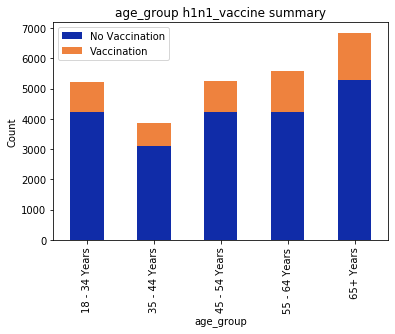

education h1n1_vaccine summary


h1n1_vaccine         0     1
education                   
12 Years          4726  1071
< 12 Years        1968   395
College Graduate  7614  2483
Some College      5579  1464
unknown           1146   261
h1n1_vaccine             0         1
education                           
12 Years          0.224695  0.188756
< 12 Years        0.093567  0.069616
College Graduate  0.362003  0.437610
Some College      0.265250  0.258019
unknown           0.054486  0.045999
h1n1_vaccine             0         1
education                           
12 Years          0.815249  0.184751
< 12 Years        0.832840  0.167160
College Graduate  0.754085  0.245915
Some College      0.792134  0.207866
unknown           0.814499  0.185501


<Figure size 432x288 with 0 Axes>

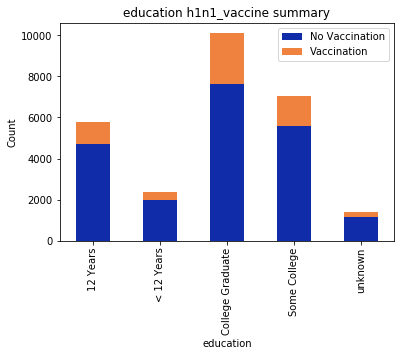

race h1n1_vaccine summary


h1n1_vaccine           0     1
race                          
Black               1803   315
Hispanic            1390   365
Other or Multiple   1263   349
White              16577  4645
h1n1_vaccine              0         1
race                                 
Black              0.085722  0.055516
Hispanic           0.066087  0.064329
Other or Multiple  0.060048  0.061509
White              0.788142  0.818646
h1n1_vaccine              0         1
race                                 
Black              0.851275  0.148725
Hispanic           0.792023  0.207977
Other or Multiple  0.783499  0.216501
White              0.781123  0.218877


<Figure size 432x288 with 0 Axes>

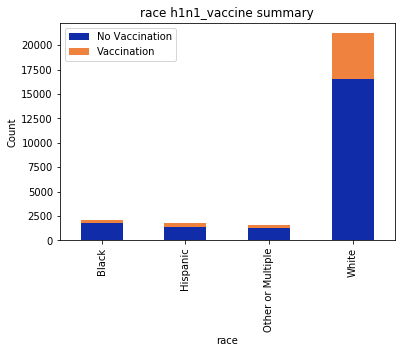

sex h1n1_vaccine summary


h1n1_vaccine      0     1
sex                      
Female        12378  3480
Male           8655  2194
h1n1_vaccine         0         1
sex                             
Female        0.588504  0.613324
Male          0.411496  0.386676
h1n1_vaccine         0         1
sex                             
Female        0.780552  0.219448
Male          0.797769  0.202231


<Figure size 432x288 with 0 Axes>

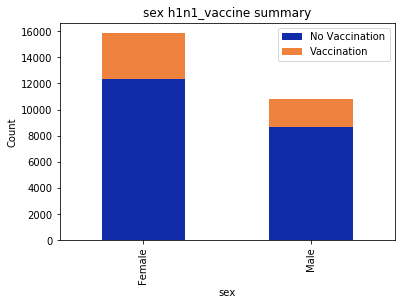

income_poverty h1n1_vaccine summary


h1n1_vaccine        0     1
income_poverty             
Above $75k       5087  1723
Above Poverty   10178  2599
Below Poverty    2181   516
unknown          3587   836
h1n1_vaccine           0         1
income_poverty                    
Above $75k      0.241858  0.303666
Above Poverty   0.483906  0.458054
Below Poverty   0.103694  0.090941
unknown         0.170542  0.147339
h1n1_vaccine           0         1
income_poverty                    
Above $75k      0.746990  0.253010
Above Poverty   0.796588  0.203412
Below Poverty   0.808676  0.191324
unknown         0.810988  0.189012


<Figure size 432x288 with 0 Axes>

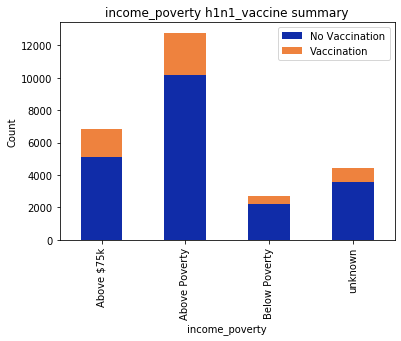

marital_status h1n1_vaccine summary


h1n1_vaccine        0     1
marital_status             
Married         10387  3168
Not Married      9494  2250
unknown          1152   256
h1n1_vaccine           0         1
marital_status                    
Married         0.493843  0.558336
Not Married     0.451386  0.396546
unknown         0.054771  0.045118
h1n1_vaccine           0         1
marital_status                    
Married         0.766286  0.233714
Not Married     0.808413  0.191587
unknown         0.818182  0.181818


<Figure size 432x288 with 0 Axes>

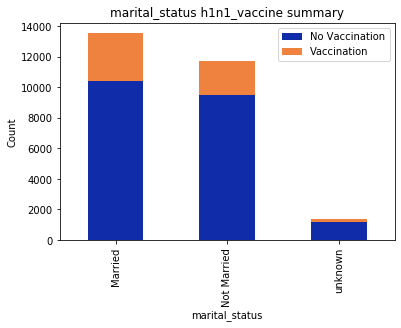

homeowner h1n1_vaccine summary


h1n1_vaccine      0     1
homeowner                
0.0            4810  1119
1.0           16223  4555
h1n1_vaccine         0         1
homeowner                       
0.0           0.228688  0.197215
1.0           0.771312  0.802785
h1n1_vaccine         0         1
homeowner                       
0.0           0.811267  0.188733
1.0           0.780778  0.219222


<Figure size 432x288 with 0 Axes>

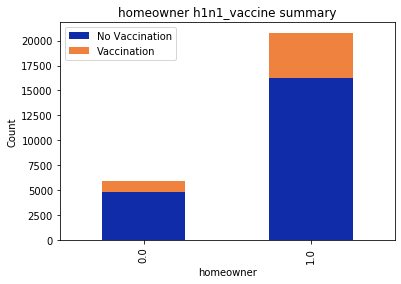

employment_status h1n1_vaccine summary


h1n1_vaccine            0     1
employment_status              
Employed            10637  2923
Not in Labor Force   7988  2243
Unemployed           1216   237
unknown              1192   271
h1n1_vaccine               0         1
employment_status                     
Employed            0.505729  0.515157
Not in Labor Force  0.379784  0.395312
Unemployed          0.057814  0.041769
unknown             0.056673  0.047762
h1n1_vaccine               0         1
employment_status                     
Employed            0.784440  0.215560
Not in Labor Force  0.780764  0.219236
Unemployed          0.836889  0.163111
unknown             0.814764  0.185236


<Figure size 432x288 with 0 Axes>

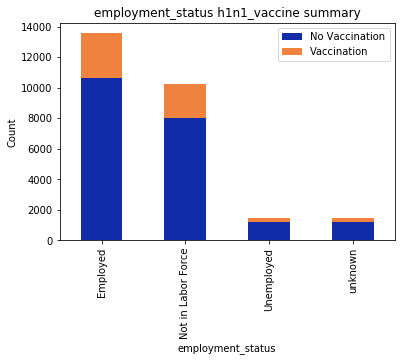

hhs_geo_region h1n1_vaccine summary


h1n1_vaccine       0    1
hhs_geo_region           
atmpeygn        1591  442
bhuqouqj        2110  736
dqpwygqj         933  193
fpwskwrf        2607  658
kbazzjca        2291  567
lrircsnp        1641  437
lzgpxyit        3523  774
mlyzmhmf        1726  517
oxchjgsf        2199  660
qufhixun        2412  690
h1n1_vaccine           0         1
hhs_geo_region                    
atmpeygn        0.075643  0.077899
bhuqouqj        0.100319  0.129714
dqpwygqj        0.044359  0.034015
fpwskwrf        0.123948  0.115968
kbazzjca        0.108924  0.099930
lrircsnp        0.078020  0.077018
lzgpxyit        0.167499  0.136412
mlyzmhmf        0.082062  0.091117
oxchjgsf        0.104550  0.116320
qufhixun        0.114677  0.121607
h1n1_vaccine           0         1
hhs_geo_region                    
atmpeygn        0.782587  0.217413
bhuqouqj        0.741391  0.258609
dqpwygqj        0.828597  0.171403
fpwskwrf        0.798469  0.201531
kbazzjca        0.80

<Figure size 432x288 with 0 Axes>

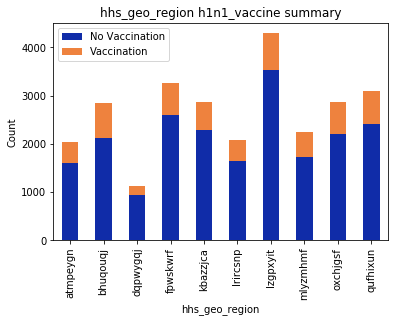

household_adults h1n1_vaccine summary


h1n1_vaccine          0     1
household_adults             
0.0                6471  1585
1.0               11419  3304
2.0                2240   563
3.0                 903   222
h1n1_vaccine             0         1
household_adults                    
0.0               0.307659  0.279344
1.0               0.542909  0.582305
2.0               0.106499  0.099225
3.0               0.042933  0.039126
h1n1_vaccine             0         1
household_adults                    
0.0               0.803252  0.196748
1.0               0.775589  0.224411
2.0               0.799144  0.200856
3.0               0.802667  0.197333


<Figure size 432x288 with 0 Axes>

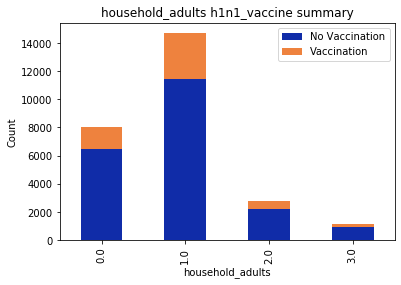

household_children h1n1_vaccine summary


h1n1_vaccine            0     1
household_children             
0.0                 14899  4022
1.0                  2501   674
2.0                  2235   629
3.0                  1398   349
h1n1_vaccine               0         1
household_children                    
0.0                 0.708363  0.708847
1.0                 0.118908  0.118787
2.0                 0.106262  0.110857
3.0                 0.066467  0.061509
h1n1_vaccine               0         1
household_children                    
0.0                 0.787432  0.212568
1.0                 0.787717  0.212283
2.0                 0.780377  0.219623
3.0                 0.800229  0.199771


<Figure size 432x288 with 0 Axes>

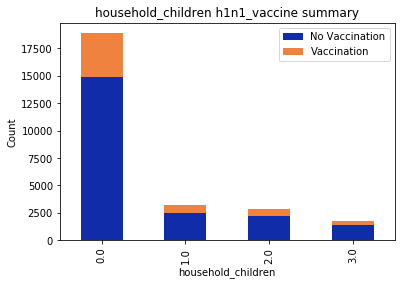

chronic_med_condition h1n1_vaccine summary


h1n1_vaccine               0     1
chronic_med_condition             
0.0                    15751  3666
1.0                     5282  2008
h1n1_vaccine                  0         1
chronic_med_condition                    
0.0                    0.748871  0.646105
1.0                    0.251129  0.353895
h1n1_vaccine                  0         1
chronic_med_condition                    
0.0                    0.811196  0.188804
1.0                    0.724554  0.275446


<Figure size 432x288 with 0 Axes>

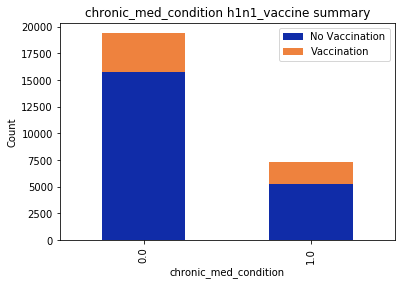

child_under_6_months h1n1_vaccine summary


h1n1_vaccine              0     1
child_under_6_months             
0.0                   19547  5022
1.0                    1486   652
h1n1_vaccine                 0        1
child_under_6_months                   
0.0                   0.929349  0.88509
1.0                   0.070651  0.11491
h1n1_vaccine                 0         1
child_under_6_months                    
0.0                   0.795596  0.204404
1.0                   0.695042  0.304958


<Figure size 432x288 with 0 Axes>

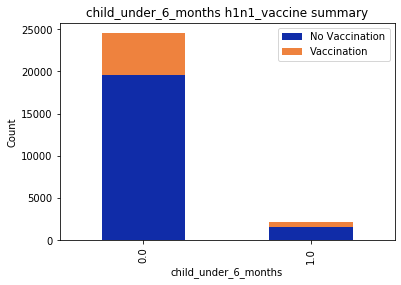

<Figure size 432x288 with 0 Axes>

In [72]:
stacked(df, dem, h1n1, ['No Vaccination', 'Vaccination'])

# <span id="4"></span>4. Feature Significance
#### [Return Contents](#0)
<hr/>

Once we determined which features appeared to have a relationship with the target variables of H1N1 and seasonal vaccinations, we went a step farther by conducting Chi-Squared tests to determine if there truly is a statistically significant correlation between each categorical feature and the target variables.

We dramatically decreased our p-value to run these Chi-Squared tests to avoid false positives, so any feature with a passing p-value is strongly correlated.

There are several features with a strong correlation with the target variable, including:
  * Doctor reccomendation for seasonal vaccine
  * Opinion seasonal vaccine effectiveness
  * Opinion seasonal flu risk 
  

In [ ]:
alpha/num of tests = 0.05/num of tests

In [105]:
failed, passed = chi_squared_loop(df, seas, .01)

seasonal_vaccine     0     1
h1n1_concern                
0.0               2254  1042
1.0               4811  3342
2.0               5185  5482
3.0               2022  2569
seasonal_vaccine     0     1
h1n1_knowledge              
0.0               1588   918
1.0               8350  6364
2.0               4334  5153
seasonal_vaccine               0      1
behavioral_antiviral_meds              
0.0                        13594  11812
1.0                          678    623
seasonal_vaccine         0     1
behavioral_avoidance            
0.0                   4337  2934
1.0                   9935  9501
seasonal_vaccine          0      1
behavioral_face_mask              
0.0                   13457  11409
1.0                     815   1026
seasonal_vaccine           0      1
behavioral_wash_hands              
0.0                     3052   1598
1.0                    11220  10837
seasonal_vaccine                0     1
behavioral_large_gatherings            
0.0                      

seasonal_vaccine                   0      1
missing_behavioral_touch_face              
0                              14206  12373
1                                 66     62
seasonal_vaccine         0      1
missing_doctor_recc              
0                    12873  11674
1                     1399    761
seasonal_vaccine             0     1
missing_health_insurance            
0                         7204  7229
1                         7068  5206
seasonal_vaccine       0      1
missing_homeowner              
0                  13086  11579
1                   1186    856
seasonal_vaccine          0      1
missing_h1n1_concern              
0                     14222  12393
1                        50     42
seasonal_vaccine            0      1
missing_h1n1_knowledge              
0                       14212  12379
1                          60     56
seasonal_vaccine       0      1
missing_household              
0                  14087  12371
1                    185    

In [106]:
failed

[['behavioral_antiviral_meds', 0.34000896763675553],
 ['child_under_6_months', 0.029922400624159774],
 ['missing_behavioral_avoidance', 0.7111665318313565],
 ['missing_behavioral_face_mask', 0.44682233480859923],
 ['missing_behavioral_wash_hands', 0.7438347933471561],
 ['missing_behavioral_large_gatherings', 0.6680250486730481],
 ['missing_behavioral_outside_home', 0.7697452979107718],
 ['missing_behavioral_touch_face', 0.7354662617027168],
 ['missing_h1n1_concern', 0.9439228920220408],
 ['missing_h1n1_knowledge', 0.7811329531726579]]

In [107]:
passed

[['h1n1_concern', 7.4399779052320865e-143],
 ['h1n1_knowledge', 3.758455089274291e-86],
 ['behavioral_avoidance', 1.8503449909099235e-35],
 ['behavioral_face_mask', 3.6346353704704425e-16],
 ['behavioral_wash_hands', 4.880484926206459e-75],
 ['behavioral_large_gatherings', 2.4581098743084737e-25],
 ['behavioral_outside_home', 3.4597040841313817e-18],
 ['behavioral_touch_face', 2.0590061927397429e-85],
 ['doctor_recc_h1n1', 9.13039447069853e-231],
 ['doctor_recc_seasonal', 0.0],
 ['chronic_med_condition', 1.1928898604662591e-168],
 ['health_worker', 1.8091553690170514e-95],
 ['health_insurance', 1.9933223642379186e-92],
 ['opinion_h1n1_vacc_effective', 4.97816632922443e-265],
 ['opinion_h1n1_risk', 1.7067730553051574e-279],
 ['opinion_h1n1_sick_from_vacc', 9.451071253515581e-10],
 ['opinion_seas_vacc_effective', 0.0],
 ['opinion_seas_risk', 0.0],
 ['opinion_seas_sick_from_vacc', 9.63441128562558e-53],
 ['age_group', 0.0],
 ['education', 1.7841137139002192e-36],
 ['race', 1.3781023743020

In [ ]:
Multi-comparison t-tests

# <span id="5"></span>5. Feature Engineering
#### [Return Contents](#0)
<hr/>

We developed a user-defined function to interact each feature.  We then checked to see if these new engineered features had correlation with the target and if they did not have correlation with their elemental features.  Engineered features that met this criteria were included in the model.  The rest were discarded to prevent multicolinearity.

We began examining various demographic factors to see if certain combinations would produce unique results that would enhance our model. To consolidate steps we called on a user created function that sets up a basic preprocessing workflow on a dataframe combined with column selection techniques that would allow us to experiment with different setups in generating/comparing polynomial features.

In [4]:
#Scaled down set up to target specific columns and generate dummies and polynomial
#interactions within the same setup. The input dictionaries contain greater variety
#in the modeling notebook.

missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"

#The dicts that come into the arguments.
continuous = {}

categorical = {
    "nominal_features":['education', "sex"],
}
polynomial = {"method":"all", "columns":[]}

In [5]:
# Instantiates the object selecting only specific categorical columns from the dataframe.
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, create_dummies=True, random_state=124)

#Performs a 2nd degree polynomial transformation on the data contained within
#that object.
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)

#Creates a mask that will hide the show only the original columns and their interactions.
masked_cols = data.get_X_train().columns.drop(extract_column_names(data.get_X_train(), "\^\d"))

Creating Dummies
Getting polynomial features of degree 2

['education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling


In [ ]:
Correlation Heat Maps

In [7]:
#Creates a custum diverging pallette to allow for greater control of hsl values between
#the two colors.
palette = independant_palette("#ee823e", "#102ca8")

<Figure size 1440x1080 with 0 Axes>

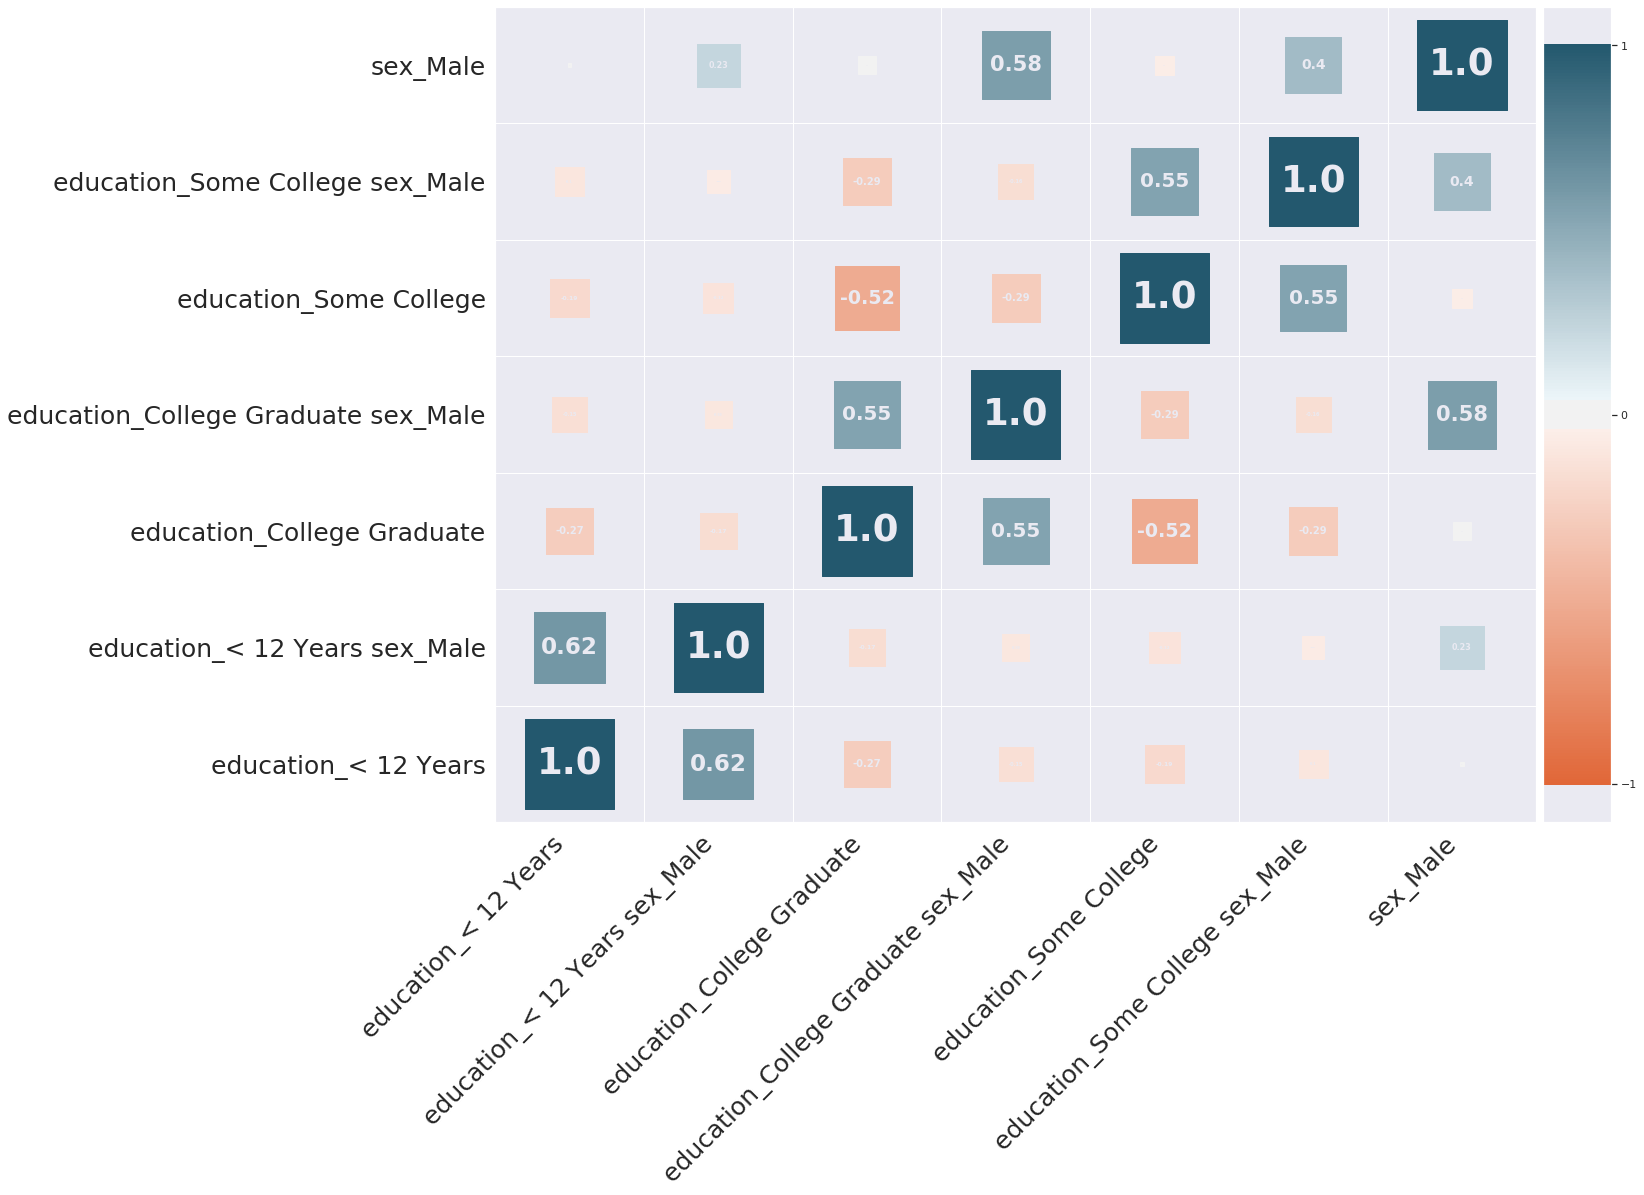

In [8]:
#Generates a heatmap examining the correlation between sex and education interactions.
dynamic_heatmap(data.get_df(), masked_cols, fontsize=25, annot=1.5,
                figsize=(20,15), squaresize=8000, palette=palette)

We repeated this step and came up with the following groups to evalue including new interactions in the model. They are a composed of a mixture containing the strongest correlations with the target variable as well interactions between various demographic data that was relatively uncorrelated with each other.

In [21]:
categorical = {
    "nominal_features":['age_group', 'income_poverty', 'education', "race", "sex"],
    "standard_dummies":['opinion_seas_vacc_effective', 'doctor_recc_seasonal', 'opinion_seas_risk']
}

In [36]:
#Instantiating a new object that will generate much more columns from interactions.
data = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)

Creating Dummies
Getting polynomial features of degree 2

['age_group_35_to_44 Years age_group_45_to_54 Years', 'age_group_35_to_44 Years age_group_55_to_64 Years', 'age_group_35_to_44 Years age_group_Over_65', 'age_group_45_to_54 Years age_group_55_to_64 Years', 'age_group_45_to_54 Years age_group_Over_65', 'age_group_55_to_64 Years age_group_Over_65', 'income_poverty_Above Poverty income_poverty_Below Poverty', 'income_poverty_Above Poverty income_poverty_unknown', 'income_poverty_Below Poverty income_poverty_unknown', 'education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College', 'race_Hispanic race_Other or Multiple', 'race_Hispanic race_White', 'race_Other or Multiple race_White']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling


In [37]:
#Once again hiding the columns of variables raised to a power. Since the possibilities are
#only zero and one they produce no new data.
squared_cols = extract_column_names(data.get_X_train(), "\^\d")
masked_cols = data.get_X_train().columns.drop(squared_cols)

#This function creates a selection of columns that had a stronger magnitude (positive
#or negative) of correlation than the inserted value of .55. That value seemed to give
#us a good balance of candidates.
corr_cols=correlated_columns_by_threshold(data.get_X_train(), masked_cols, .55)

#Through some manipulation of set routes on Pandas Index objects we removed the columns
#with that strong correlation along with the earlier polynomial columns to mask.
poly_corr_cols = np.intersect1d(corr_cols, data.cols_polynomial)
data.cols_polynomial.drop([*poly_corr_cols, *squared_cols])
to_drop = np.intersect1d(data.cols_polynomial, [*poly_corr_cols, *squared_cols])
data.column_drop(to_drop)

Adding ['opinion_seas_vacc_effective^2', 'opinion_seas_vacc_effective doctor_recc_seasonal', 'opinion_seas_vacc_effective opinion_seas_risk', 'opinion_seas_vacc_effective age_group_35_to_44 Years', 'opinion_seas_vacc_effective age_group_45_to_54 Years', 'opinion_seas_vacc_effective age_group_55_to_64 Years', 'opinion_seas_vacc_effective age_group_Over_65', 'opinion_seas_vacc_effective income_poverty_Above Poverty', 'opinion_seas_vacc_effective income_poverty_Below Poverty', 'opinion_seas_vacc_effective income_poverty_unknown', 'opinion_seas_vacc_effective education_< 12 Years', 'opinion_seas_vacc_effective education_College Graduate', 'opinion_seas_vacc_effective education_Some College', 'opinion_seas_vacc_effective race_Hispanic', 'opinion_seas_vacc_effective race_Other or Multiple', 'opinion_seas_vacc_effective race_White', 'opinion_seas_vacc_effective sex_Male', 'doctor_recc_seasonal^2', 'doctor_recc_seasonal opinion_seas_risk', 'doctor_recc_seasonal age_group_55_to_64 Years', 'doct

In [38]:
#We also wanted to set up a dataframe that excludes the original columms and includes
#The target variable for easy comparison afterwards
test_df = data.get_df()[data.get_df().columns.drop(data.cols_initial).union([target_col1])]

In [45]:
#This provided a list of columns from that selection that had correlations of above
#.1 with the target variable. We saved these values and will use them in lists of column
#selection for the next notebook.
thresh = df_test_threshhold(test_df.corr().tail(10).T, target_col1, .1)
interaction_cols = test_df.corr().tail(10).T.[target_col1][thresh].index.drop(target_col1)
interaction_cols

Index(['doctor_recc_seasonal education_Some College', 'doctor_recc_seasonal sex_Male'], dtype='object')

And we repeated the process to find interaction candidates for the other target variable as well.

In [ ]:
#Instantiating a new object that will generate much more columns from interactions.
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)

#Once again hiding the columns of variables raised to a power. Since the possibilities are
#only zero and one they produce no new data.
squared_cols = extract_column_names(data.get_X_train(), "\^\d")
masked_cols = data.get_X_train().columns.drop(squared_cols)

#This function creates a selection of columns that had a stronger magnitude (positive
#or negative) of correlation than the inserted value of .55. That value seemed to give
#us a good balance of candidates.
corr_cols=correlated_columns_by_threshold(data.get_X_train(), masked_cols, .55)

#Through some manipulation of set routes on Pandas Index objects we removed the columns
#with that strong correlation along with the earlier polynomial columns to mask.
poly_corr_cols = np.intersect1d(corr_cols, data.cols_polynomial)
data.cols_polynomial.drop([*poly_corr_cols, *squared_cols])
to_drop = np.intersect1d(data.cols_polynomial, [*poly_corr_cols, *squared_cols])
data.column_drop(to_drop)

#We also wanted to set up a dataframe that excludes the original columms and includes
#The target variable for easy comparison afterwards
test_df = data.get_df()[data.get_df().columns.drop(data.cols_initial).union([target_col2])]

In [48]:
#This provided a list of columns from that selection that had correlations of above
#.1 with the target variable. We saved these values and will use them in lists of column
#selection for the next notebook.
thresh = df_test_threshhold(test_df.corr().tail(10).T, target_col2, .1)
interaction_cols = test_df.corr().tail(10).T[target_col2][thresh].index.drop(target_col2)
interaction_cols


Index(['age_group_Over_65 education_College Graduate',
       'age_group_Over_65 sex_Male',
       'doctor_recc_seasonal age_group_45_to_54 Years',
       'doctor_recc_seasonal education_Some College',
       'doctor_recc_seasonal income_poverty_unknown',
       'doctor_recc_seasonal sex_Male'],
      dtype='object')